# ETL Project
## Members:
* Francisco Estevez
* Alvin Kim
### Data Sources
We extracted data from the Machine Learning Course offered by Google
https://developers.google.com/machine-learning/crash-course/
The dataset we selected is part of the Data preparation of the course
#### Collecting Data > The Size and Quality of a Data Set
The data source contains 20 Millions of records:
    * Movies from 1891 to 2015
    * Rates
    * Genome Scores
#### Final database
Our information is stored in Mongo DB:
    * Movie Rates
    * Movie Genome Scores

### Notebook 1: Extract, cleanse and filter Movies Data

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

### Store CSV into DataFrame

In [2]:
csv_file = "Resources/movies.csv"
movies_df = pd.read_csv(csv_file)
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
movieId    27278 non-null int64
title      27278 non-null object
genres     27278 non-null object
dtypes: int64(1), object(2)
memory usage: 639.4+ KB


In [4]:
movies_df.describe()

,movieId
count,27278.000000
mean,59855.480570
std,44429.314697
min,1.000000
25%,6931.250000
50%,68068.000000
75%,100293.250000
max,131262.000000


### Clean TAGS from data

In [5]:
# Eliminate spaces from Beginning and End of every TITLE
movies_df['title'] = movies_df['title'].str.strip()

In [20]:
movie_movieId = movies_df['movieId']
movie_names = movies_df['title'].str[:-6]
movie_years = movies_df['title'].str[-5:-1]
movie_genres = movies_df['genres'].str.split("|")

In [7]:
len(movie_years)

27278

### Identify non numeric values in the YEARS series

In [8]:
nonNumeric = 0
garbage_list = []
clean_list = []
for x in range(len(movie_years)):
    try:
       val = int(movie_years[x])
       clean_list.append(x)
    except ValueError:
       # print("Year Error", movies_df['title'][x])
        nonNumeric += 1
        garbage_list.append(x)
print (f"total number of non Numeric values {nonNumeric}")
print (f"IDs to exclude from the Movie's series {garbage_list}")

total number of non Numeric values 22
IDs to exclude from the Movie's series [10593, 15646, 17341, 19859, 22368, 22669, 23617, 23824, 24286, 24412, 26115, 26127, 26180, 26335, 26395, 26432, 26749, 26784, 26963, 26974, 27027, 27114]


In [9]:
movies_summary_pd = pd.to_numeric(movie_years[clean_list])
first_year = movies_summary_pd.min()
last_year = movies_summary_pd.max() 
print (f"Clean list of movies includes movies from {first_year} to {last_year}")


Clean list of movies includes movies from 1891 to 2015


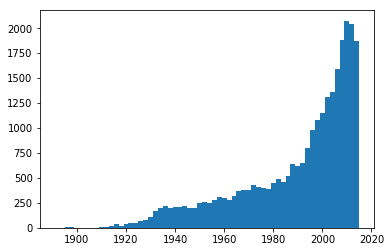

In [10]:
plt.hist(movies_summary_pd, bins=range(first_year, last_year + 2, 2));

### The following is a list of the movies excluded due to lack of YEAR

In [11]:
movies_excluded = len(movies_df['title'][garbage_list])
print (f"Final list with {movies_excluded} movies excluded")

Final list with 22 movies excluded


In [12]:
movies_df['title'][garbage_list]

10593                                            Babylon 5
15646              Millions Game, The (Das Millionenspiel)
17341     Bicycle, Spoon, Apple (Bicicleta, cullera, poma)
19859    Mona and the Time of Burning Love (Mona ja pal...
22368                         Diplomatic Immunity (2009– )
22669                         Big Bang Theory, The (2007-)
23617                Brazil: In the Shadow of the Stadiums
23824                                   Slaying the Badger
24286                           Tatort: Im Schmerz geboren
24412                  National Theatre Live: Frankenstein
26115                 The Court-Martial of Jackie Robinson
26127                                        In Our Garden
26180                   Stephen Fry In America - New World
26335                       Two: The Story of Roman & Nyro
26395                                        Li'l Quinquin
26432                      A Year Along the Abandoned Road
26749                                           Body/Cia

#### Datasets are combined into a single Data Frame for filtering Movies with no YEAR

In [21]:
movies_clean_years = {
    'movieId': movie_movieId[clean_list],
    'Movie'  : movie_names[clean_list], 
    'Years'  : movie_years[clean_list],
    'Genres' : movie_genres[clean_list]
}
movies_clean_years_df = pd.DataFrame(movies_clean_years) 
movies_clean_years_df.head(5)

,movieId,Movie,Years,Genres
0,1,Toy Story,1995,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji,1995,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men,1995,"[Comedy, Romance]"
3,4,Waiting to Exhale,1995,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II,1995,[Comedy]


### Evaluation of GENRES

In [14]:
genres_dic = {}
for movie in movies_clean_years_df.Genres:
    for genres in movie:
        if genres_dic.get(genres) is None:
            genres_dic[genres] = 1
        else:
            genres_dic[genres] += 1

#### Some movies will be exclueded due to lack of GENRE (No genres listed)

In [15]:
sorted(genres_dic.items())

[('(no genres listed)', 237),
 ('Action', 3519),
 ('Adventure', 2329),
 ('Animation', 1027),
 ('Children', 1139),
 ('Comedy', 8370),
 ('Crime', 2938),
 ('Documentary', 2467),
 ('Drama', 13339),
 ('Fantasy', 1411),
 ('Film-Noir', 330),
 ('Horror', 2611),
 ('IMAX', 196),
 ('Musical', 1035),
 ('Mystery', 1513),
 ('Romance', 4127),
 ('Sci-Fi', 1741),
 ('Thriller', 4177),
 ('War', 1194),
 ('Western', 676)]

#### List the Movies which will be exluded due to lack of GENRE '(no genres listed)'

In [22]:
to_exclude = '(no genres listed)'
mylambda = lambda item: to_exclude in item
movies_clean_years_df[movies_clean_years_df.Genres.apply(mylambda)]

,movieId,Movie,Years,Genres
16574,83773,Away with Words (San tiao ren),1999,[(no genres listed)]
16589,83829,Scorpio Rising,1964,[(no genres listed)]
16764,84768,Glitterbug,1994,[(no genres listed)]
17080,86493,"Age of the Earth, The (A Idade da Terra)",1980,[(no genres listed)]
17243,87061,Trails (Veredas),1978,[(no genres listed)]
18246,91246,Milky Way (Tejút),2007,[(no genres listed)]
18566,92435,"Dancing Hawk, The (Tanczacy jastrzab)",1978,[(no genres listed)]
18606,92641,Warsaw Bridge (Pont de Varsòvia),1990,[(no genres listed)]
18984,94431,"Ella Lola, a la Trilby",1898,[(no genres listed)]
19015,94657,"Turkish Dance, Ella Lola",1898,[(no genres listed)]


#### Create the clean version of the Movies file with YEARS and Genres

In [23]:
to_exclude = '(no genres listed)'
mylambda = lambda item: to_exclude not in item
movies_clean_DF = movies_clean_years_df[movies_clean_years_df.Genres.apply(mylambda)]
print (f"Cleansed and filtered movies file includes {len(movies_clean_DF)} movies")

Cleansed and filtered movies file includes 27019 movies


### Save Cleansed and Filtered dataset as CSV file

In [24]:
movies_clean_DF.to_csv(f"Resources/cleansed_movies_data.csv", index=False)